In [ ]:
import torch
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset

tran_list = [transforms.Resize((256,256))]
transform_test = transforms.Compose(tran_list)

ds = BRATSDataset('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001', transform_test)

datal = torch.utils.data.DataLoader(
    ds,
    batch_size=1,
    shuffle=True)

import matplotlib.pyplot as plt
from scipy import ndimage

b, m, slide_id = next(iter(datal))

from guided_diffusion.utils import visualize, dice_coeff
t1, t1ce, t2, flair = visualize(b, m)


# from guided_diffusion.unet_parts import BasicUNet
# import torch.nn.functional as F
# seg = BasicUNet(n_channels=4, n_classes=1)
# checkpoint = torch.load('model_nonnormalized.pth')
# seg.load_state_dict(checkpoint['model_state_dict'])
# seg.eval()

# ipex_enabled = False
# bf16 = True

# import time
# start_time = time.time()
# if ipex_enabled:
#     import intel_extension_for_pytorch as ipex
#     if bf16:
#         seg = ipex.optimize(seg, dtype=torch.bfloat16)
#         with torch.no_grad(), torch.cpu.amp.autocast():
#             m_pred = F.sigmoid(seg(b.to(torch.float32)))
#     else:
#         seg = ipex.optimize(seg)
#         m_pred = F.sigmoid(seg(b.to(torch.float32))).detach()
# else:
#     m_pred = F.sigmoid(seg(b.to(torch.float32))).detach()

# print(time.time() - start_time)
# print(dice_coeff(m_pred, m))
# visualize(b, m_pred)

In [ ]:
import os
import time
import torch
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset
from guided_diffusion.utils import post_process
from guided_diffusion.script_util import create_model_and_diffusion

data_dir = 'data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001'
image_size = 256
batch_size = 1
ipex_enabled = True
bf16 = True
num_ensemble = 1
diffusion_steps = 20
in_ch = 5

tran_list = [transforms.Resize((image_size,image_size))]
transform_test = transforms.Compose(tran_list)

ds = BRATSDataset(data_dir,transform_test)

datal = torch.utils.data.DataLoader(
    ds,
    batch_size=batch_size,
    shuffle=True)

model, diffusion = create_model_and_diffusion(image_size=image_size, in_ch=in_ch, diffusion_steps=diffusion_steps, version=1)

######################
# checkpoint = torch.load(model_path)
# model.load_state_dict(checkpoint['model_state_dict'], strict=False)
######################

model.eval()

if ipex_enabled:
    import intel_extension_for_pytorch as ipex
    print("Intel(R) Extension for PyTorch* enabled")
    if bf16:
        print("BF16 enabled")
        model = ipex.optimize(model, dtype=torch.bfloat16)
    else:
        model = ipex.optimize(model)

b, m, slice_ID = next(iter(datal))  #should return an image from the dataloader "data"
c = torch.randn_like(b[:, :1, ...])
img = torch.cat((b, c), dim=1)     #add a noise channel$

enslist = []

for i in range(num_ensemble):  #this is for the generation of an ensemble of 5 masks.
    model_kwargs = {}

    sample_fn = diffusion.p_sample_loop_known
    start_time = time.time()

    if ipex_enabled and bf16:
        with torch.no_grad(), torch.cpu.amp.autocast():
            sample, x_noisy, org, cal, cal_out = sample_fn(
                model,
                (batch_size, in_ch, image_size, image_size), img, ipex_enabled,
                step = diffusion_steps,
                clip_denoised=True,
                model_kwargs=model_kwargs,
            )
    else:
        sample, x_noisy, org, cal, cal_out = sample_fn(
            model,
            (batch_size, in_ch, image_size, image_size), img, 
            ipex_enabled, bf16=False,
            step = diffusion_steps,
            clip_denoised=True,
            model_kwargs=model_kwargs,
        )
        
    ensemble_step_time = time.time() - start_time
    post_processed_m = post_process(sample)

    print("--- %s seconds ---" % (ensemble_step_time))


In [ ]:
from guided_diffusion.utils import visualize, dice_coeff
visualize(img, post_processed_m)

In [ ]:
from guided_diffusion.utils import dice_coeff
dice_coeff(post_processed_m, m)

In [ ]:
import nibabel as nib
img = nib.load('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii.gz')

In [ ]:
import torch
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset
from guided_diffusion.utils import visualize

tran_list = [transforms.Resize((256,256))]
transform_test = transforms.Compose(tran_list)

ds = BRATSDataset('data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001', transform_test)

datal = torch.utils.data.DataLoader(
    ds,
    batch_size=1,
    shuffle=True)

b, m, slide_id = next(iter(datal))
t1, t1ce, t2, flair = visualize(b, m)


In [ ]:
input_img = '001'
if input_img == '002':
    print('true')

In [ ]:
import torch
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset
from guided_diffusion.utils import visualize

import gradio as gr

def segment_tumor(input_img, sequence_type, optimization):

    tran_list = [transforms.Resize((256,256))]
    transform_test = transforms.Compose(tran_list)

    ds = BRATSDataset(f'data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{input_img}', transform_test)

    datal = torch.utils.data.DataLoader(
        ds,
        batch_size=1,
        shuffle=True)

    b, m, slide_id = next(iter(datal))
    t1, t1ce, t2, flair = visualize(b, m)
    
    if sequence_type == 't1':
        output_img = t1
    elif sequence_type == 't1ce':
        output_img = t1ce
    elif sequence_type == 't2':
        output_img = t2
    elif sequence_type == 'flair':
        output_img = flair

    return output_img, sequence_type, optimization

demo = gr.Interface(
    fn=segment_tumor, 
    inputs=[gr.Dropdown(['001', '002']), gr.Dropdown(['t1', 't1ce', 't2', 'flair']), gr.Dropdown(['Stock PyTorch*', 'Intel(R) Extension for PyTorch*'])], 
    outputs=["image", "text", "text"], 
    live=False, 
    title="ACCELERATE DIFFUSION MODELS FOR MEDICAL SEGMENTATION",
    css="footer {visibility: hidden}"
)

demo.launch(share=True)

In [ ]:
import torch
import torchvision.transforms as transforms
from guided_diffusion.bratsloader import BRATSDataset
from guided_diffusion.utils import visualize, dice_coeff

import gradio as gr

def segment_tumor(input_img, sequence_type, optimization):

    tran_list = [transforms.Resize((256,256))]
    transform_test = transforms.Compose(tran_list)

    ds = BRATSDataset(f'data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{input_img}', transform_test)

    datal = torch.utils.data.DataLoader(
        ds,
        batch_size=1,
        shuffle=True)

    b, m, slide_id = next(iter(datal))
    t1, t1ce, t2, flair = visualize(b, m)
    
    if sequence_type == 't1':
        output_img = t1
    elif sequence_type == 't1ce':
        output_img = t1ce
    elif sequence_type == 't2':
        output_img = t2
    elif sequence_type == 'flair':
        output_img = flair
        
    dice_score = f"Dice Coefficient: {dice_coeff(m.int(), m.int()):.2f}"

    return output_img, dice_score


demo = gr.Interface(
    fn=segment_tumor, 
    inputs=[gr.Dropdown(['001', '002'], label="Input Image"), 
            gr.Dropdown(['t1', 't1ce', 't2', 'flair'], label="Sequence Type"), 
            gr.Dropdown(['Stock PyTorch*', 'Intel(R) Extension for PyTorch*'], label="Optimization")], 
    outputs=[gr.Image(label="Tumor Segmentation Prediction"),
             gr.Textbox(label="Accuracy")], 
    live=False, 
    title="ACCELERATE DIFFUSION MODELS FOR MEDICAL SEGMENTATION",
    allow_flagging='never',
    css="footer {visibility: hidden}",
)

demo.launch(share=True)

In [ ]:
dice_score = f"Dice Coefficient: {dice_coeff(m.squeeze(), m.squeeze()):.2f}"
print(dice_score)

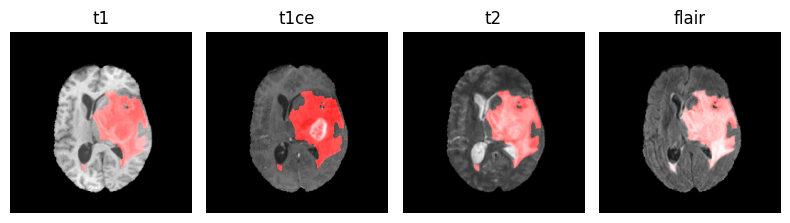

In [43]:
import os
import time

import torch
import torchvision.transforms as transforms

from guided_diffusion.bratsloader import BRATSDataset
from guided_diffusion.utils import post_process, visualize, dice_coeff
from guided_diffusion.script_util import create_model_and_diffusion

import gradio as gr

def segment_tumor(input_img, sequence_type, optimization):
    
    data_dir = 'data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001'
    diffusion_steps = 20

    tran_list = [transforms.Resize((256,256))]
    transform_test = transforms.Compose(tran_list)

    ds = BRATSDataset(f'data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{input_img}', transform_test)

    datal = torch.utils.data.DataLoader(
        ds,
        batch_size=1,
        shuffle=True)

    model, diffusion = create_model_and_diffusion(image_size=256, in_ch=5, diffusion_steps=diffusion_steps, version=1)
    model.eval()

    if optimization=='Enabled':
        import intel_extension_for_pytorch as ipex
        model = ipex.optimize(model, dtype=torch.bfloat16)

    b, m, slice_ID = next(iter(datal))  #should return an image from the dataloader "data"
    c = torch.randn_like(b[:, :1, ...])
    img = torch.cat((b, c), dim=1)     #add a noise channel$
    
    model_kwargs = {}

    sample_fn = diffusion.p_sample_loop_known
    start_time = time.time()

    if optimization=='Enabled':
        with torch.no_grad(), torch.cpu.amp.autocast():
            sample, _, _, _, _ = sample_fn(
                model,
                (1, 5, 256, 256), img, optimization,
                step = diffusion_steps,
                clip_denoised=True,
                model_kwargs=model_kwargs,
            )
    else:
        sample, _, _, _, _ = sample_fn(
            model,
            (1, 5, 256, 256), img, 
            optimization,
            step = diffusion_steps,
            clip_denoised=True,
            model_kwargs=model_kwargs,
        )

    ensemble_step_time = f"{time.time() - start_time:.2f}"
    post_processed_m = post_process(sample)

    t1, t1ce, t2, flair = visualize(b, post_processed_m)

    if sequence_type == 't1':
        output_img = t1
    elif sequence_type == 't1ce':
        output_img = t1ce
    elif sequence_type == 't2':
        output_img = t2
    elif sequence_type == 'flair':
        output_img = flair
        
    dice_score = f"Dice Coefficient: {dice_coeff(post_processed_m, m):.2f}"

    return output_img, dice_score, ensemble_step_time

output_img, dice_score, ensemble_step_time = segment_tumor('001', 't1', 'Enabled')

In [47]:
output_img.type()

AttributeError: 'numpy.ndarray' object has no attribute 'type'

In [50]:
import os
import time

import torch
import torchvision.transforms as transforms

from guided_diffusion.bratsloader import BRATSDataset
from guided_diffusion.utils import post_process, visualize, dice_coeff
from guided_diffusion.script_util import create_model_and_diffusion

import gradio as gr

def segment_tumor(input_img, sequence_type, optimization):
    
    data_dir = 'data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001'
    diffusion_steps = 20

    tran_list = [transforms.Resize((256,256))]
    transform_test = transforms.Compose(tran_list)

    ds = BRATSDataset(f'data/MICCAI_BraTS2020_TrainingData/BraTS20_Training_{input_img}', transform_test)

    datal = torch.utils.data.DataLoader(
        ds,
        batch_size=1,
        shuffle=True)

    model, diffusion = create_model_and_diffusion(image_size=256, in_ch=5, diffusion_steps=diffusion_steps, version=1)
    model.eval()

    if optimization=='Enabled':
        import intel_extension_for_pytorch as ipex
        model = ipex.optimize(model, dtype=torch.bfloat16)

    b, m, slice_ID = next(iter(datal))  #should return an image from the dataloader "data"
    c = torch.randn_like(b[:, :1, ...])
    img = torch.cat((b, c), dim=1)     #add a noise channel$
    
    model_kwargs = {}

    sample_fn = diffusion.p_sample_loop_known
    start_time = time.time()

    if optimization=='Enabled':
        with torch.no_grad(), torch.cpu.amp.autocast():
            sample, _, _, _, _ = sample_fn(
                model,
                (1, 5, 256, 256), img, optimization,
                step = diffusion_steps,
                clip_denoised=True,
                model_kwargs=model_kwargs,
            )
    else:
        sample, _, _, _, _ = sample_fn(
            model,
            (1, 5, 256, 256), img, 
            optimization,
            step = diffusion_steps,
            clip_denoised=True,
            model_kwargs=model_kwargs,
        )

    ensemble_step_time = f"{time.time() - start_time:.2f}"
    post_processed_m = post_process(sample)

    t1, t1ce, t2, flair = visualize(b, post_processed_m)

    if sequence_type == 't1':
        output_img = t1
    elif sequence_type == 't1ce':
        output_img = t1ce
    elif sequence_type == 't2':
        output_img = t2
    elif sequence_type == 'flair':
        output_img = flair
        
    dice_score = f"Dice Coefficient: {dice_coeff(post_processed_m, m):.2f}"

    return output_img, dice_score, ensemble_step_time


demo = gr.Interface(
    fn=segment_tumor, 
    inputs=[gr.Dropdown(['001', '002'], label="Input Image"), 
            gr.Dropdown(['t1', 't1ce', 't2', 'flair'], label="Sequence Type"), 
            gr.Dropdown(['Disabled', 'Enabled'], label="Optimization")], 
    outputs=[gr.Image(label="Tumor Segmentation Prediction"),
             gr.Textbox(label="Accuracy"),
             gr.Textbox(label="Inference time (s)")], 
    live=False, 
    title="ACCELERATE DIFFUSION MODELS FOR MEDICAL SEGMENTATION",
    allow_flagging='never',
    css="footer {visibility: hidden}",
)

demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7865
Running on public URL: https://5bb1d3828406dc512b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


/mnt/localdisk1/kta/MedSegDiff/MedSegDiff/guided_diffusion/gaussian_diffusion.py:167: RuntimeWarning: divide by zero encountered in true_divide
  self.sqrt_recip_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod)
/mnt/localdisk1/kta/MedSegDiff/MedSegDiff/guided_diffusion/gaussian_diffusion.py:168: RuntimeWarning: divide by zero encountered in true_divide
  self.sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod - 1)
/mnt/localdisk1/kta/env/MedSegDiff/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:474: UserWarning: Conv BatchNorm folding failed during the optimize process.
  warnings.warn("Conv BatchNorm folding failed during the optimize process.")
/mnt/localdisk1/kta/env/MedSegDiff/lib/python3.10/site-packages/intel_extension_for_pytorch/frontend.py:479: UserWarning: Linear BatchNorm folding failed during the optimize process.
  warnings.warn("Linear BatchNorm folding failed during the optimize process.")
/mnt/localdisk1/kta/env/MedSegDiff/lib/pytho